# Reconstructing the Treaty of Tlatelolco Application Zone

[The Treaty of Tlatelolco](https://opanal.org/en/zone-of-application/) contains this description of the application zone (Article 4):

> Upon fulfillment of the requirements of Article 29, paragraph 1, the Zone of Application of this Treaty shall also be that which is situated in the western hemisphere within the following limits (except the continental part of the territory of the United States of America and its territorial waters): starting at a point located at 35º north latitude, 75º west longitude; from this point directly southward to a point at 30º north latitude, 75º west longitude; from there, directly eastward to a point at 30º north latitude, 50º west longitude; from there, along a loxodromic line to a point at 5º north latitude, 20º west longitude; from there, directly southward to a point at 60º south latitude, 20º west longitude; from there, directly westward to a point at 60º south latitude, 115º west longitude; from there, directly northward to a point at 0º latitude, 115º west longitude; from there, along a loxodromic line to a point at 35º north latitude, 150º west longitude; from there, directly eastward to a point at 35º north latitude, 75º west longitude.

We'll contruct this geometry by writing out the straight line segments, then subtracting the combined area of the United States its territorial waters.


In [5]:
import geopandas as gp
import shapely as shp
import sys

sys.path.append('..')
import utils.close_holes

world_admin0 = gp.read_file("./tmp/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp")
usa_12nm = gp.read_file("./tmp/usa_12nm_exterior.shp")

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
16,Admin-0 country,5,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576..."


(24.0, 35.0)

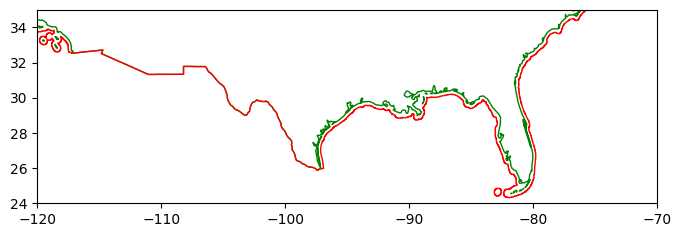

In [6]:
# Prepare United States geometry
usa_land = world_admin0.loc[world_admin0["ADM0_A3"] == "USA"]
usa_geo = shp.union_all([usa_land.geometry, usa_12nm.geometry], grid_size=.01)
usa_territory = gp.GeoDataFrame(data={"geometry":[usa_geo]}, geometry="geometry")
usa_territory.geometry = usa_territory.geometry.apply(lambda x: utils.close_holes.close_holes(x))

# Plot
ax = usa_territory.plot(figsize=(8,8), color="none", edgecolor="red")
usa_land.plot(ax=ax, color="none", edgecolor="green",zorder=-10)
ax.set_xlim([-120,-70])
ax.set_ylim([24, 35])

In [7]:
# Build treaty extent geometry 
treaty_geo = shp.geometry.Polygon(
    [
    # ...starting at a point located at 35º north latitude, 75º west longitude;
    (-75,35),
    # from this point directly southward to a point at 30º north latitude, 75º west longitude;
    (-75, 30),
    # from there, directly eastward to a point at 30º north latitude, 50º west longitude;
    (-50, 30),
    # from there, along a loxodromic line to a point at 5º north latitude, 20º west longitude;
    (-20, 5),
    # from there, directly southward to a point at 60º south latitude, 20º west longitude;
    (-20, -60),
    # from there, directly westward to a point at 60º south latitude, 115º west longitude;
    (-115, -60),
    # from there, directly northward to a point at 0º latitude, 115º west longitude;
    (-115, 0),
    # from there, along a loxodromic line to a point at 35º north latitude, 150º west longitude;
    (-150, 35)
    # (omitting return to origin)
    ]
)

# ...except the continental part of the territory of the United States of America and its territorial waters
treaty_geo = shp.difference(treaty_geo, usa_territory.geometry).explode(index_parts=True)

treaty_extent = gp.GeoDataFrame(
    data={
        "geometry": [
            *list(treaty_geo),
        ]
    },
    geometry="geometry",
    crs="EPSG:4326",
)

treaty_extent.geometry = treaty_extent.geometry.apply(lambda x: x.segmentize(max_segment_length=1))

treaty_extent.to_file("./tmp/tlatelolco-extent.geojson")

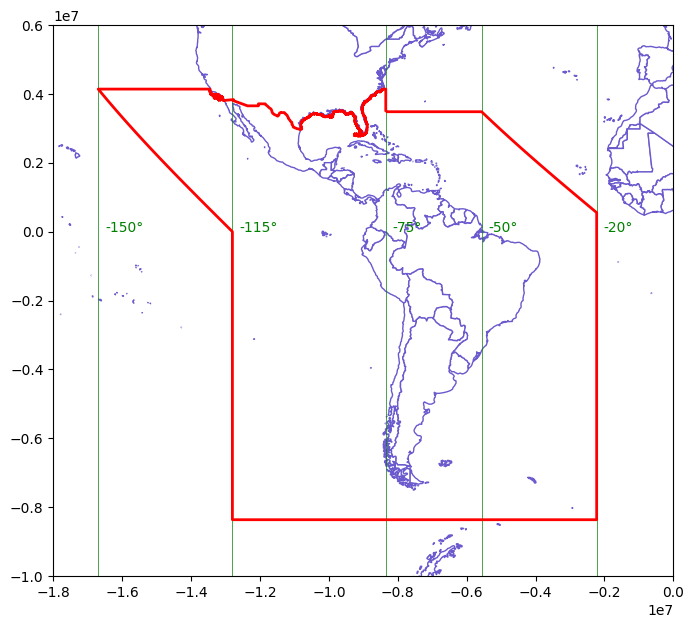

In [8]:
# Plot
proj4 = "+proj=merc"
treaty_extent_proj = treaty_extent.to_crs(crs=proj4)
countries_proj = world_admin0.to_crs(crs=proj4)

treaty_extent_proj = treaty_extent.to_crs(crs=proj4)
ax = countries_proj.plot(edgecolor="slateblue",color="white", figsize=(8,8))
treaty_extent_proj.plot(zorder=100, edgecolor="red", color="none", lw=2, ax=ax)

ax.set_xlim([-1.8e7,0e7])
ax.set_ylim([-1e7, .6e7])
long20 = shp.geometry.LineString([(-20, -90), (-20, 90)])
long75 = shp.geometry.LineString([(-75, -90), (-75, 90)])
long50 = shp.geometry.LineString([(-50, -90), (-50, 90)])
long115 = shp.geometry.LineString([(-115, -90), (-115, 90)])
long150 = shp.geometry.LineString([(-150, -90), (-150, 90)])

longs = gp.GeoDataFrame(
    data={
        "name":["-75°", "-115°", "-150°", "-20°", "-50°"],
        "geometry": [long75, long115, long150, long20, long50]},
    crs="EPSG:4326").to_crs(proj4)

longs.plot(ax=ax, lw=.5,edgecolor="green")
longs.apply(lambda x:
            ax.annotate(
                text=x['name'],
                color="green",
                xy=x.geometry.centroid.coords[0],
                xytext=(
                    x.geometry.centroid.coords[0][0] + 2e5,
                    x.geometry.centroid.coords[0][1]),
                ha='left'),
                axis=1);